In [45]:
library(repr)
options(repr.plot.width=10,repr.plot.height=7)

In [46]:
# Fast but approximate solution under Sqrt assumptions

sig <- 0.01;
ADV <- 48000000;
n <- 480000;
t <- 24/390;
vavg <- n/(ADV*t+n);

In [47]:
# Instantaneous market impact functions
# LLOB approximation.
f_llob <- function(v, sigma = pi / 4) {
  # Sgima = pi/4 is an approximation.
  # sigma <- 0.785186408814605
  m <- log(pi)
  sqrt(2 * v) * exp((-sqrt((log(v) - m)^2 + sigma^2) - m + log(v)) / 4)
}

# Blows up at 1.
f_barrier <- function(v){
  # Fit to VWAP data
  b <- .803742;
  alpha <- 0.644777844;
  beta <- 0.10;
  s <- 0.15;
  b*(v^alpha +beta*v/(1-v)^2);
}

In [48]:
f <- function(v) { f_barrier(v) + f_llob(v * 10e3) }
f <- function(v) { f_llob(v * 10e3) }

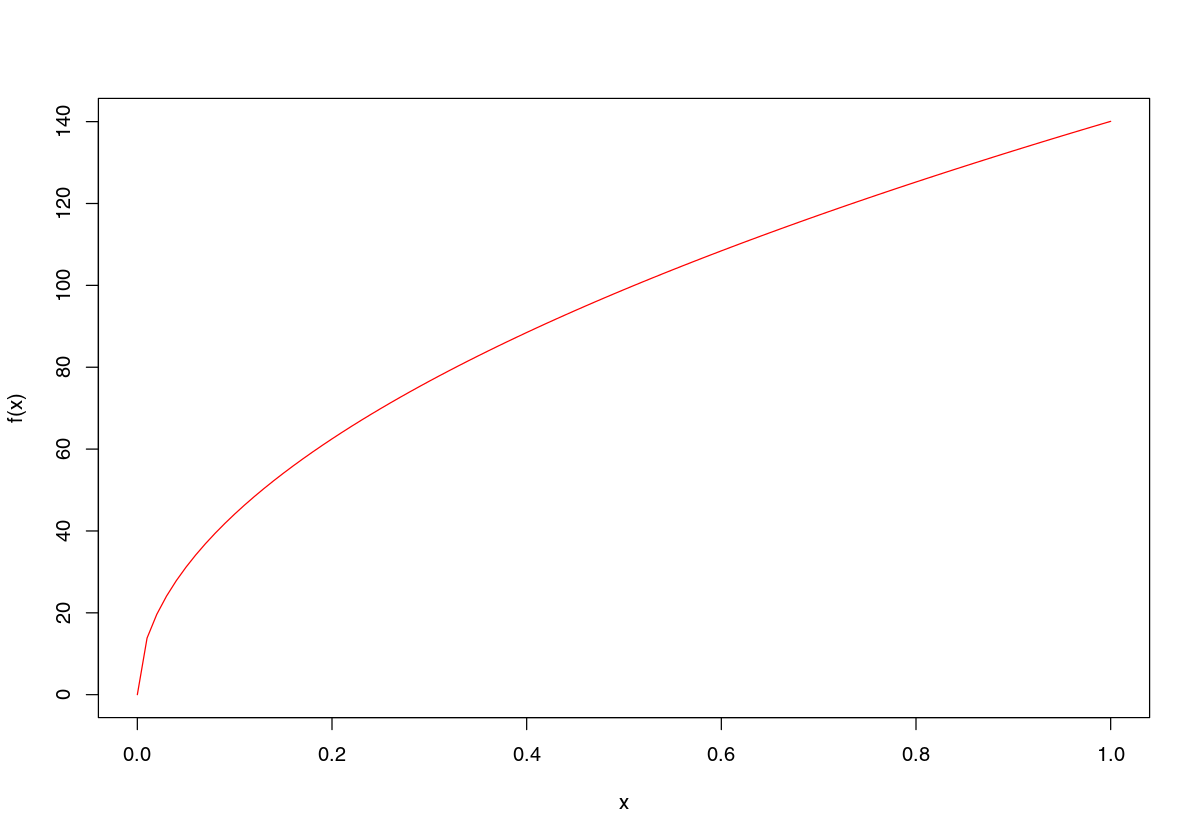

In [49]:
curve(f(x),from=0,to=1,col="red")

In [50]:
# Generate an even schedule of bursts
schedule <- function(n, epsilon, nSlices) {
  epsilon <- min(epsilon, 1) # Cap epsilon at whole subinterval
  nt <- (nSlices - 1)
  dT <- t / (nt + epsilon)
  ti <- (0:nt) * dT
  vavg <- n / (ADV * t + n)
  veps <- 1 / (1 + epsilon * (1 / vavg - 1))
  fv <- f(veps)
  bb <- cbind(ti, 0, 0, 0)
  be <- cbind(ti + epsilon * dT, n / nSlices, veps, fv)
  tmp <- rbind(bb, be)
  sched <- tmp[order(tmp[, 1]), ]
  colnames(sched) <- c("Time", "nShrs", "volFrac", "f_veps")
  return(sched)
}

In [51]:
# Use theta * m / T as epsilon.
(sched1 <- schedule(480e3,12/120,12))

Time         nShrs volFrac   f_veps  
 [1,] 0.0000000000     0 0.0000000   0.0000
 [2,] 0.0005544006 40000 0.6190476 110.1475
 [3,] 0.0055440055     0 0.0000000   0.0000
 [4,] 0.0060984061 40000 0.6190476 110.1475
 [5,] 0.0110880111     0 0.0000000   0.0000
 [6,] 0.0116424116 40000 0.6190476 110.1475
 [7,] 0.0166320166     0 0.0000000   0.0000
 [8,] 0.0171864172 40000 0.6190476 110.1475
 [9,] 0.0221760222     0 0.0000000   0.0000
[10,] 0.0227304227 40000 0.6190476 110.1475
[11,] 0.0277200277     0 0.0000000   0.0000
[12,] 0.0282744283 40000 0.6190476 110.1475
[13,] 0.0332640333     0 0.0000000   0.0000
[14,] 0.0338184338 40000 0.6190476 110.1475
[15,] 0.0388080388     0 0.0000000   0.0000
[16,] 0.0393624394 40000 0.6190476 110.1475
[17,] 0.0443520444     0 0.0000000   0.0000
[18,] 0.0449064449 40000 0.6190476 110.1475
[19,] 0.0498960499     0 0.0000000   0.0000
[20,] 0.0504504505 40000 0.6190476 110.1475
[21,] 0.0554400554     0 0.0000000   0.0000
[22,] 0.0559944560 40000 0.6190476 110.1475
[23,] 0.0609840610     0 0.0000000   0.0000
[24,] 0.0615384615 40000 0.6190476 110.1475

In [52]:
# Compute volume fraction for even schedule
fveps <- function(n, epsilon, nSlices) {
  vavg <- n / (ADV * t + n)
  veps <- 1 / (1 + epsilon * (1 / vavg - 1))
  return(f(veps))
}

In [53]:
# pj computes the impact of all prior executions on the price in the jth bucket (from t[j] to t[j+1))
pj <- function(t, v, fv, j) {
  pj <- fv[j] * sqrt(t[j + 1] - t[j]) # Self-interaction term
  if (j > 1) {
    for (i in 1:(j - 1))
    {
      decay <- ((t[j + 1] - t[i])^(3 / 2) - (t[j] - t[i])^(3 / 2) - (t[j + 1] - t[i + 1])^(3 / 2) + (t[j] - t[i + 1])^(3 / 2)) / (t[j + 1] - t[j])
      pj <- pj + decay * fv[i]
    }
  }
  return(pj)
}

In [54]:
# Finally, the function that costs a particular schedule
costSchedule <- function(sched) {
  tt <- sched[, 1] # Remember that first element is t=0!
  m <- length(tt)
  dt <- diff(tt)
  nn <- sched[, 2][2:m]
  v <- nn / (ADV * dt + nn) # Volume fractions include own volume in denominator!
  ff <- function(vv) {
    f(vv)
  }
  fv <- as.numeric(lapply(v, ff))
  cost <- 0
  for (j in 1:(m - 1)) {
    cost <- cost + nn[j] * pj(tt, v, fv, j)
  }
  return(cost * sig / n)
}

In [55]:
# Now, the function that accurately apporoximates the cost of regular bursts of trading
# Note that this function works just as well with non-integer nSlices!
costEvenSchedule <- function(n, epsilon, nSlices) {
  m <- nSlices
  crossSum <- (5 * (-1 + sqrt(-1 + m)) - 2 * (4 + 9 * sqrt(-1 + m)) * m + 16 * m^2) / (12 * sqrt(-1 + m) * m) # Accurate approximation to discrete sum of prior influences
  diag <- sig * fveps(n, epsilon, nSlices) * sqrt(epsilon * t / (nSlices + epsilon)) # diagonal term
  cross <- 3 / 4 * sig * fveps(n, epsilon, nSlices) * epsilon * sqrt(t / (nSlices + epsilon)) * crossSum
  return(diag + cross)
}

In [56]:
costEvenSchedule(n,12/120,12)

[1] 0.04338287

In [57]:
# Compare numbers
costEvenSchedule(n,12/120,120)
costSchedule(schedule(n,12/120,120))
# Numbers agree!

[1] 0.03239855

[1] 0.03256029

In [58]:
# Now given a clock-time duration theta for a slice, we can compute the cost for any given 
# trading fraction epsilon
costEpsilon <- function(epsilon,theta){
  return(costEvenSchedule(n,epsilon,t*epsilon/theta));
}

In [66]:
# Finally, finally, a function to compute the optimal strategy given theta (the characteristic timescale)
optimalStrategy <- function(theta) {
  res <- optimize(function(eps) {
    costEpsilon(eps, theta)
  }, c(0, 0.4))
  epsilon <- res$minimum
  nSlices <- round(t * epsilon / theta, 0)
  cost <- res$objective
  tmp <- cbind(nSlices, epsilon, cost)
  names(tmp) <- c("nSlices", "epsilon", "cost")
  return(as.data.frame(tmp))
}

In [67]:
(res <- optimalStrategy(12/60/390))
#  nSlices   epsilon         cost
#1      17 0.1432919 0.0003535013
# LLOB
#        1 0.012454  0.0001612811
# LLOB(v*10e3) + barrier
#        2 0.020398  0.0335341

nSlices epsilon    cost      
1 1       0.01036182 0.03101235

In [68]:
# The optimal schedule is given by
sched <- schedule(n,res$epsilon,res$nSlices);
costSchedule(sched);
# [1] 0.0003547257

[1] 0.1295238

In [69]:
sched1 <- schedule(n,res$epsilon,res$nSlices+1);
costSchedule(sched1)

[1] 0.03442086

In [70]:
sched2 <- schedule(n,res$epsilon,res$nSlices-1);
costSchedule(sched2)

[1] NaN

In [71]:
sched3 <- schedule(n,res$epsilon,res$nSlices+2);
costSchedule(sched3);

[1] 0.02547863

In [65]:
sched4 <- schedule(n,res$epsilon,res$nSlices+4);
costSchedule(sched4);

[1] 0.01903967